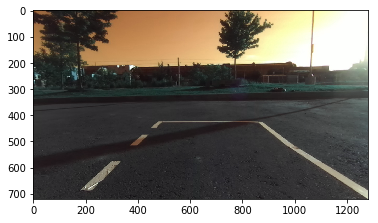

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img_bgr = cv2.imread("Lanes/Urban_Race/urban_sunny3.jpg")
img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)

plt.imshow(img_bgr)

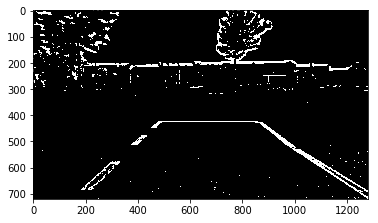

In [3]:
(channel_h, channel_s, channel_v) = cv2.split(img_hsv)
adaptive_thres = cv2.adaptiveThreshold(channel_v, 255, 
                                       cv2.ADAPTIVE_THRESH_MEAN_C, 
                                       cv2.THRESH_BINARY, 25, -20)

                               
plt.imshow(adaptive_thres, cmap='gray')

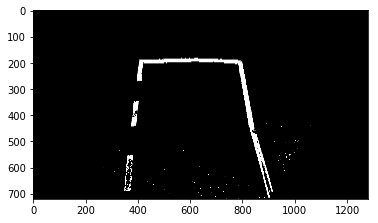

In [5]:
# Circuit race: (2m wide lanes)
# src = np.float32([[500,350], [750,350], [1280,550], [0,450]])

# Drag race: (1.5m wide lanes)
# src = np.float32([[400,350], [760,350], [1280,500], [0,500]])

# Urban race: (1m wide lanes)
src = np.float32([[420,380], [930,380], [1280,720], [50,720]])

dst = np.float32([[300, 0], [900,0], [900,720], [300,720]])

img_size = (adaptive_thres.shape[1], adaptive_thres.shape[0])
    
M = cv2.getPerspectiveTransform(src, dst)
warped = cv2.warpPerspective(adaptive_thres, M, img_size)

plt.imshow(warped, cmap='gray')

In [ ]:
# Contours
blob_size = 200
filtered = np.zeros(warped.shape, np.uint8)

contours, _ = cv2.findContours(warped, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

for cnt in contours:
    if cv2.contourArea(cnt) >= blob_size: 
        cv2.drawContours(filtered, [cnt], -1, 255, -1)

plt.imshow(filtered, cmap='gray')

cv2.imshow('test',filtered)
cv2.waitKey(0) 
cv2.destroyAllWindows()